# Customer Churn Prediction using Amazon SageMaker Notebook and Sklearn

---
Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

This notebook demonstrates the use of Amazon SageMaker’s Notebook

Note: This notebook was tested in Amazon SageMaker Notebook on ml.t3.medium instance with Python 3 (Data Science) kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Data Preparation and Visualization](#2.-Data-Preparation-and-Visualization)
3. [Train model](#3.-Train-a-Logistic-regression)


## 1. Set Up

---
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.

---

In [1]:
!pip install sagemaker ipywidgets --upgrade --quiet


---
To train and host on Amazon SageMaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3.

---

In [2]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-churn"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sklearn import preprocessing

## 2. Data Preparation and Visualization

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes. After all, predicting the future is tricky business! But we’ll learn how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. Let’s download and read that dataset in now:

In [4]:
s3 = boto3.client("s3")
s3.download_file(
    f"sagemaker-example-files-prod-{aws_region}",
    "datasets/tabular/synthetic/churn.txt",
    "churn.txt",
)

In [5]:
churn = pd.read_csv("./churn.txt")
pd.set_option("display.max_columns", 500)
churn.head(5)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


By modern standards, it’s a relatively small dataset, with only 5,000 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

`State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ

`Account Length`: the number of days that this account has been active

`Area Code`: the three-digit area code of the corresponding customer’s phone number

`Phone`: the remaining seven-digit phone number

`Int’l Plan`: whether the customer has an international calling plan: yes/no

`VMail Plan`: whether the customer has a voice mail feature: yes/no

`VMail Message`: the average number of voice mail messages per month

`Day Mins`: the total number of calling minutes used during the day

`Day Calls`: the total number of calls placed during the day

`Day Charge`: the billed cost of daytime calls

`Eve Mins`, `Eve Calls`, `Eve Charge`: the billed cost for calls placed during the evening

`Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime

`Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls

`CustServ Calls`: the number of calls placed to Customer Service

`Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute: the attribute that we want the ML model to predict. Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let’s begin exploring the data:

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


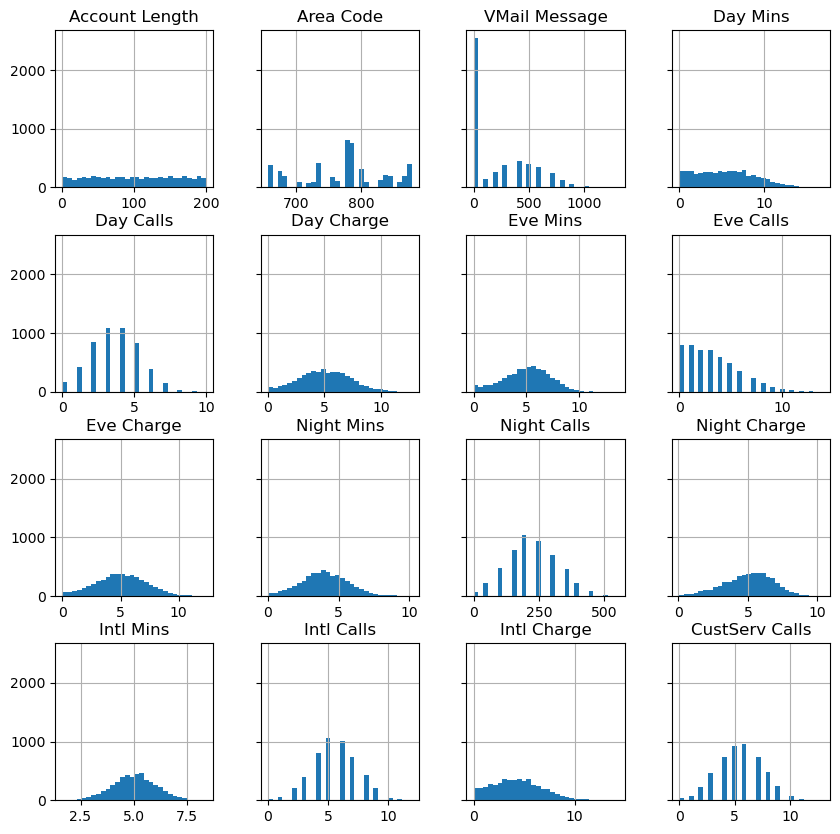

In [6]:
# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that: - `State` appears to be quite evenly distributed. - `Phone` takes on too many unique values to be of any practical use. It’s possible that parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it. - Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. `VMail Message` is a notable exception.

In [7]:
churn = churn.drop("Phone", axis=1)
churn["Area Code"] = churn["Area Code"].astype(object)

Next let’s look at the relationship between each of the features and our target variable.

Churn?,False.,True.
State,,
AK,0.015588,0.018415
AL,0.021583,0.018415
AR,0.022782,0.021217
AZ,0.015588,0.020416
CA,0.020384,0.021217
CO,0.018785,0.017614
CT,0.015588,0.020016
DC,0.022382,0.022418
DE,0.018385,0.018014


Churn?,False.,True.
Area Code,,
657,0.037170,0.036829
658,0.022782,0.021217
659,0.015588,0.020416
676,0.020384,0.021217
677,0.018785,0.017614
678,0.015588,0.020016
686,0.040767,0.040432
707,0.019984,0.015612
716,0.017986,0.015212


Churn?,False.,True.
Int'l Plan,,
no,0.5,0.502802
yes,0.5,0.497198


Churn?,False.,True.
VMail Plan,,
no,0.496403,0.498799
yes,0.503597,0.501201


Account Length


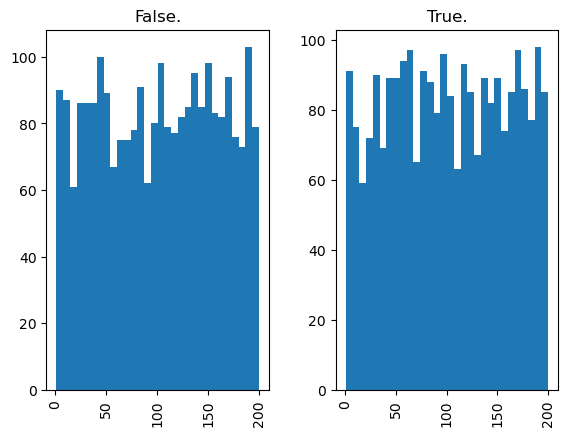

VMail Message


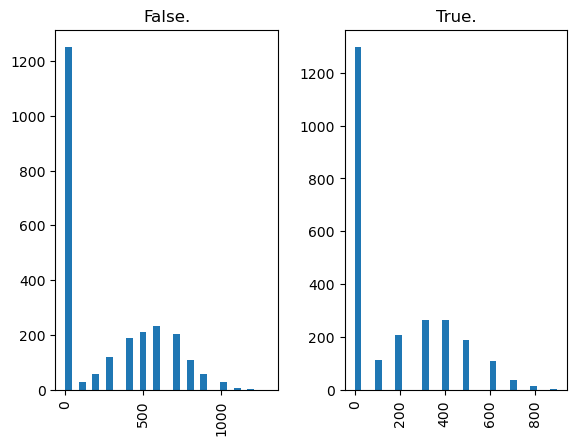

Day Mins


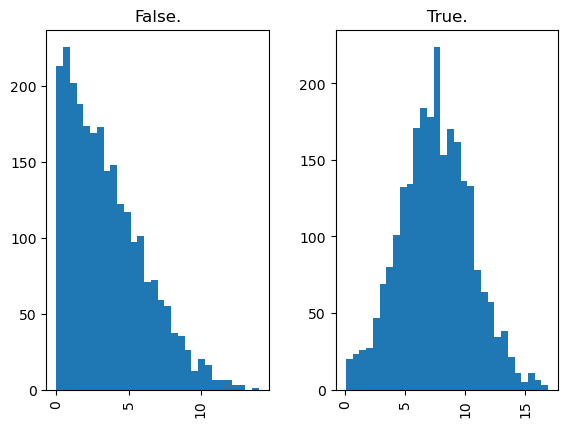

Day Calls


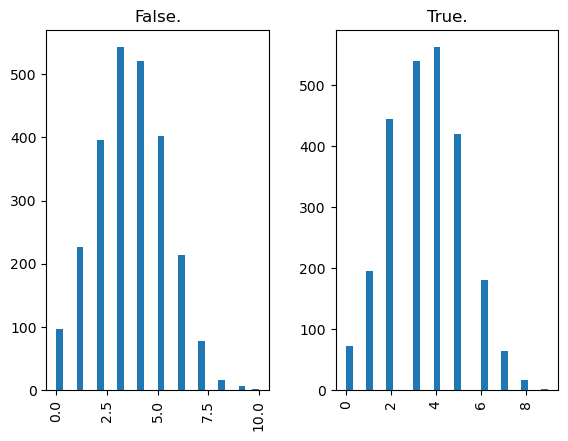

Day Charge


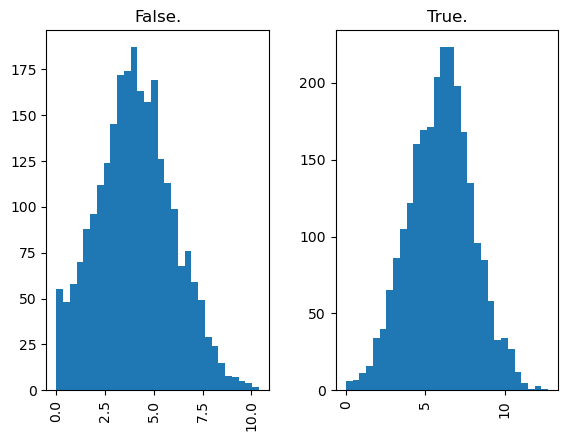

Eve Mins


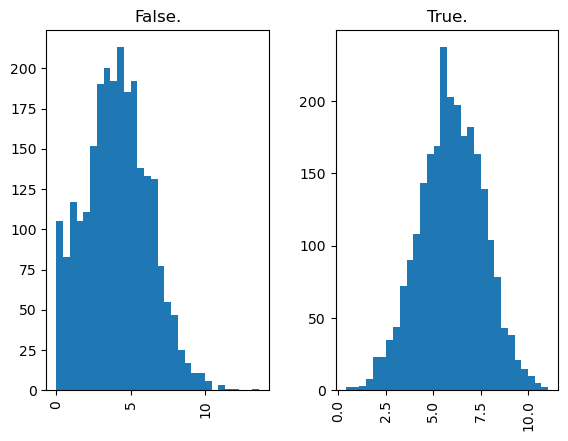

Eve Calls


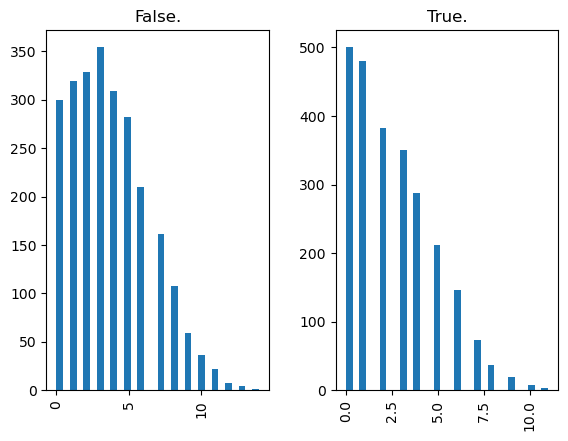

Eve Charge


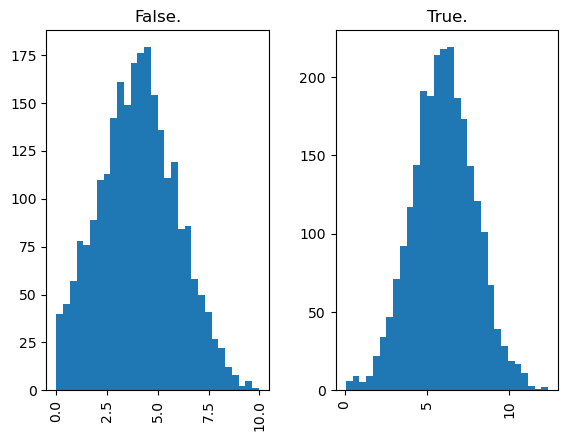

Night Mins


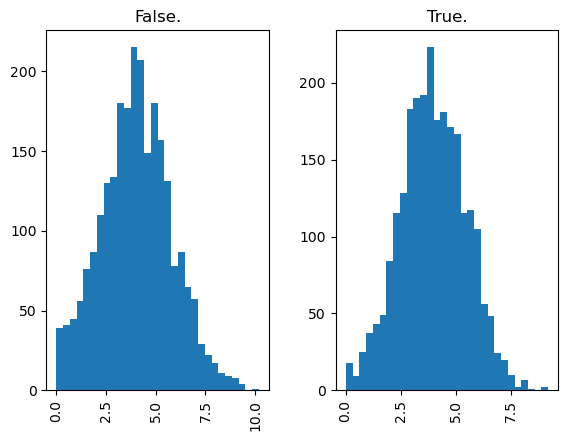

Night Calls


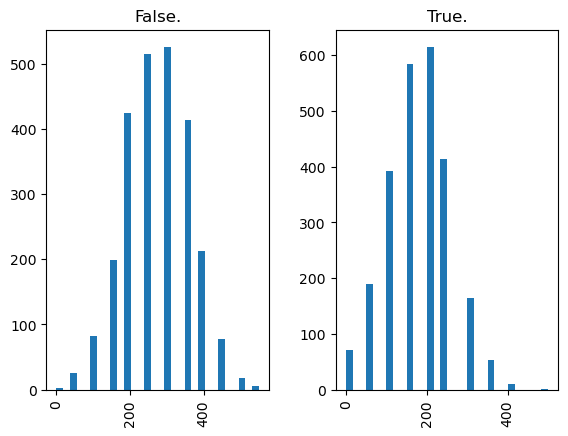

Night Charge


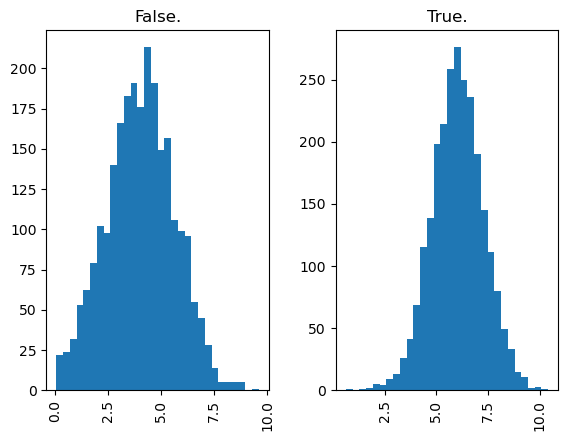

Intl Mins


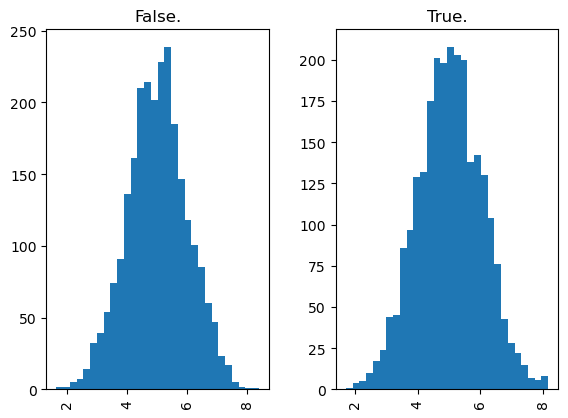

Intl Calls


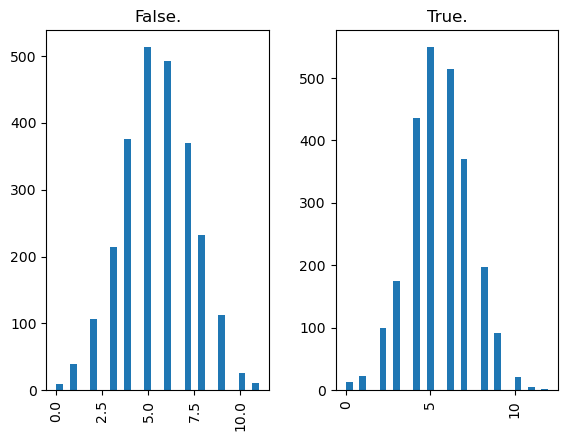

Intl Charge


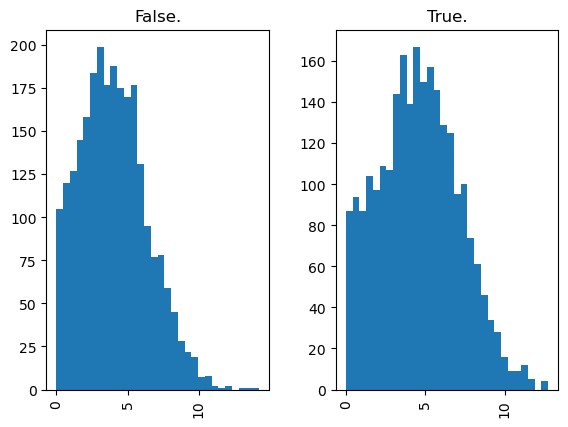

CustServ Calls


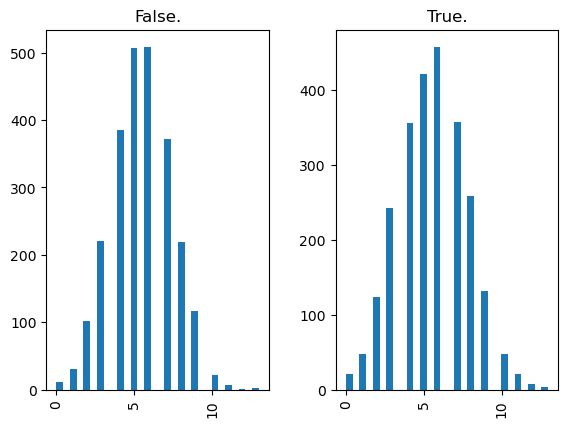

In [8]:
for column in churn.select_dtypes(include=["object"]).columns:
    if column != "Churn?":
        display(pd.crosstab(index=churn[column], columns=churn["Churn?"], normalize="columns"))

for column in churn.select_dtypes(exclude=["object"]).columns:
    print(column)
    hist = churn[[column, "Churn?"]].hist(by="Churn?", bins=30)
    plt.show()

We convert the target attribute to binary value and move it to the first column of the dataset to meet requirements of SageMaker built-in tabular algorithms (For an example, see [SageMaker LightGBM documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm.html)).  However, we do not ue Sagemaker algorithm, we do use sklearn

In [9]:
churn["target"] = churn["Churn?"].map({"True.": 1, "False.": 0})
churn.drop(["Churn?"], axis=1, inplace=True)

In [10]:
churn = churn[["target"] + churn.columns.tolist()[:-1]]

In [11]:
cat_columns = [
    "State",
    "Account Length",
    "Area Code",
    "Phone",
    "Int'l Plan",
    "VMail Plan",
    "VMail Message",
    "Day Calls",
    "Eve Calls",
    "Night Calls",
    "Intl Calls",
    "CustServ Calls",
]

cat_idx = []
for idx, col_name in enumerate(churn.columns.tolist()):
    if col_name in cat_columns:
        cat_idx.append(idx)

In [12]:
with open("cat_idx.json", "w") as outfile:
    json.dump({"cat_idx": cat_idx}, outfile)

Make all categorical features be encoded as non-negative integers. We do it consistently for all the other algorithms.

In [13]:
for idx, col_name in enumerate(churn.columns.tolist()):
    if col_name in cat_columns:
        le = preprocessing.LabelEncoder()
        churn[col_name] = le.fit_transform(churn[col_name])

We split the churn dataset into train, validation, and test set using stratified sampling. Validation set is used for early stopping and AMT. Test set is used for performance evaluations in the end. Next, we upload them into a S3 path for training.

The structure of the S3 path for training should be structured as below. The `cat_idx.json` is categorical column indexes.

-- `train`<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- `data.csv`<br>
-- `validation`<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- `data.csv`    
-- `cat_idx.json`

In [14]:
from sklearn.model_selection import train_test_split

train, val_n_test = train_test_split(
    churn, test_size=0.3, random_state=42, stratify=churn["target"]
)

In [15]:
val_n_test.head()

,target,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
3622,1,42,145,25,0,1,4,9.199507,4,8.357733,6.434082,4,7.667574,4.269727,3,4.318362,5.929763,5,8.619849,4
1346,0,49,86,32,1,0,0,0.572250,5,3.916939,2.583896,3,3.803293,1.821972,4,2.785054,5.264862,7,3.931949,5
2319,0,26,160,16,1,0,0,4.454187,2,4.711339,4.862243,3,5.723081,6.610138,9,2.392583,7.156435,7,7.468817,4
1311,1,5,64,4,0,0,0,13.983000,4,6.586997,6.799925,0,10.814623,3.773441,1,7.364881,5.254790,6,7.595761,2
4349,0,29,18,17,0,1,4,0.598415,4,2.630651,1.324419,3,3.281204,4.358745,3,2.484053,6.380484,5,3.546215,6


In [16]:
val, test = train_test_split(
    val_n_test, test_size=0.3, random_state=42, stratify=val_n_test["target"]
)

In [17]:
train.to_csv("train.csv", header=False, index=False)
val.to_csv("validation.csv", header=False, index=False)
test.to_csv("test.csv", header=False, index=False)

In [18]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/data.csv")
).upload_file("train.csv")

In [19]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/data.csv")
).upload_file("validation.csv")

In [20]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "test/data.csv")
).upload_file("test.csv")

In [21]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "cat_idx.json")
).upload_file("cat_idx.json")

## 3. Train a Logistic regression

In [22]:
y_train = train.target
X_train = train.drop(['target'], axis=1)

In [23]:
y_test = val_n_test.target
X_test = val_n_test.drop(['target'], axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [36]:
confusion_matrix(y_test, clf.predict(X_test))

array([[648, 103],
       [100, 649]])

In [42]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       751
           1       0.86      0.87      0.86       749

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [39]:
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [40]:
model.predict_proba(X_test)

array([[0.10598866, 0.89401134],
       [0.94065082, 0.05934918],
       [0.99898554, 0.00101446],
       ...,
       [0.9521605 , 0.0478395 ],
       [0.55953328, 0.44046672],
       [0.22400723, 0.77599277]])

In [41]:
confusion_matrix(y_test, model.predict(X_test))

array([[661,  90],
       [ 80, 669]])

In [30]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       751
           1       0.88      0.89      0.89       749

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



In [31]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

In [32]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None, obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string, callable or None, optional, default: None
              A string (see model evaluation documentation)
              or a scorer callable object / function with signature scorer(estimator, X, y)
              For Python 3.5 the documentation is here:
              http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
              For example, Log Loss is specified as 'neg_log_loss'

    obj_line : numeric or None (default: None)
               draw a horizontal line


    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).


    Citation
    --------
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

    Usage
    -----
        plot_learning_curve(estimator = best_estimator,
                            title     = best_estimator_title,
                            X         = X_train,
                            y         = y_train,
                            ylim      = (-1.1, 0.1), # neg_log_loss is negative
                            cv        = StatifiedCV, # CV generator
                            scoring   = scoring,     # eg., 'neg_log_loss'
                            obj_line  = obj_line,    # horizontal line
                            n_jobs    = n_jobs)      # how many CPUs

         plt.show()
    """
    from sklearn.model_selection import learning_curve
    import numpy as np
    from matplotlib import pyplot as plt

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

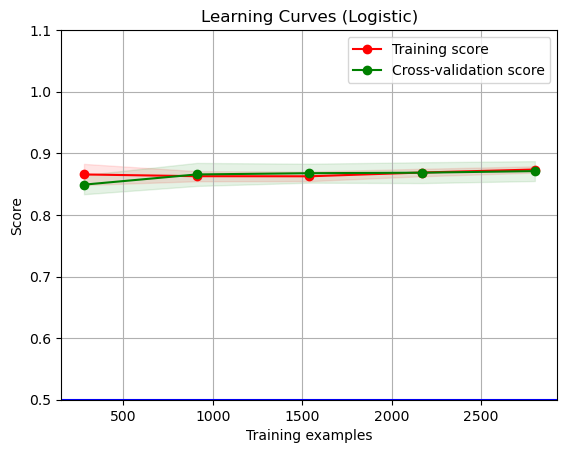

In [33]:
estimator =  LogisticRegression(solver='liblinear', random_state=0)
plot_learning_curve(estimator = estimator,
                    title     = "Learning Curves (Logistic)",
                    X         = X_train,
                    y         = y_train,
                    ylim      = (0.5, 1.1),
                    cv        = StratifiedKFold(),
                    scoring   = 'accuracy',     
                    obj_line  = 0.5,    
                    n_jobs    = -1)  
plt.show()
